# Sign Language Image Classification with Vision Transformers

### Dataset Preprocessing  for Vision Transformer (ViT) Model

### **Load Dataset**
   - The dataset is loaded using Keras's `image_dataset_from_directory` function.
   - Images are resized to 224x224 to match the input size of the ViT model.

### **Model and Feature Extractor Loading**:
   - The Vision Transformer model `vit-tiny-patch16` is loaded from the `transformers` library.
   - The corresponding feature extractor is also loaded to preprocess images for the model.

### **Preprocessing**:
   - A `preprocess_vit` function applies the feature extractor transformations to normalize and prepare images for the ViT model.
   - The dataset is mapped to this preprocessing function with parallelization for improved performance.

### **Dataset Splitting**:
   - The dataset is split into training (70%), validation (10%), and testing (20%) subsets.


### Install packages

### Import packages

In [1]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


c:\Users\myrto\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Load dataset

In [3]:
from datasets import load_dataset

# Specify the correct paths for the train and test datasets
train_dataset_path = dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-language-gesture-images-dataset\Gesture Image Data"


# Load the train and test datasets separately using `imagefolder` format
train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)

# Print dataset details to verify
print("Train Dataset:", train_dataset)


Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 55500
    })
})


In [3]:
import os
import pickle
from datasets import load_dataset

# Specify dataset paths
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-language-gesture-images-dataset\Gesture Image Data"

# Cache filenames for train and test datasets
train_cache_file = "gesture_image_dataset_cache.pkl"

# Load train dataset from cache or source
if os.path.exists(train_cache_file):
    print("Loading train dataset from cache...")
    with open(train_cache_file, "rb") as f:
        train_dataset = pickle.load(f)
else:
    print("Loading train dataset from source and caching it...")
    train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
    with open(train_cache_file, "wb") as f:
        pickle.dump(train_dataset, f)


# Print dataset details to verify
print("Train Dataset:", train_dataset)


Loading train dataset from cache...
Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 55500
    })
})


In [7]:
from PIL import Image

# Corrected file path based on your message
img = Image.open("D:/Master/DNN/sign-language-image-detection/src/ViT/sign-language-gesture-images-dataset/Gesture Image Data/1/1.jpg")

# Print the image dimensions (width, height)
print(f'Image dimensions: {img.size}')




Image dimensions: (50, 50)


In [8]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std


In [9]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [10]:
# Ensure you're passing the correct split of the dataset to CustomDataset
train_split = train_dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.5273, 0.4508, 0.4121])
Std: tensor([0.1950, 0.2325, 0.2580])


In [11]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [12]:
num_classes = calculate_num_classes(train_dataset['train'])


In [13]:
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 37


In [4]:
# mean, std = calculate_mean_std(dataset['train'])
mean = [0.5273, 0.4508, 0.4121]
std = [0.1950, 0.2325, 0.2580]


In [15]:
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

Number of classes: 37
 calculated mean: [0.5273, 0.4508, 0.4121]
 calculated std: [0.195, 0.2325, 0.258]


In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder 
# Apply transformation to datasets

transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with calculated mean and std
])

train_dataset = ImageFolder(root=train_dataset_path, transform=transform_norm)


total_size = len(train_dataset)
train_size = int(0.7 * total_size)  # 70% for training
val_size = int(0.2 * total_size)    # 20% for validation
test_size = total_size - train_size - val_size  # Remaining 10% for testing

train_split, val_split, test_split = random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_split, batch_size=batch_size, shuffle=False)

In [18]:
for images, labels in train_loader_resized:
    print(images.shape)  # Should print [64, 3, 224, 224]
    break  # Just to check one batch

torch.Size([64, 3, 224, 224])


In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot class distribution with enhanced visualization
def plot_class_distribution(dataset, title):
    # Count occurrences of each class
    class_counts = Counter([dataset[i][1] for i in range(len(dataset))])
    
    # Sort class labels and counts
    labels, counts = zip(*sorted(class_counts.items()))
    
    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 6))  # Set figure size (adjust as needed)
    
    # Plot the distribution
    plt.bar(labels, counts, tick_label=[str(label) for label in labels], color='skyblue')
    plt.xlabel('Class Labels', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.title(title, fontsize=16)
    
    # Rotate tick labels for better readability if there are many classes
    plt.xticks( fontsize=12)
    
    # Increase the size of the y-axis labels and ticks for better visibility
    plt.yticks(fontsize=12)
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()




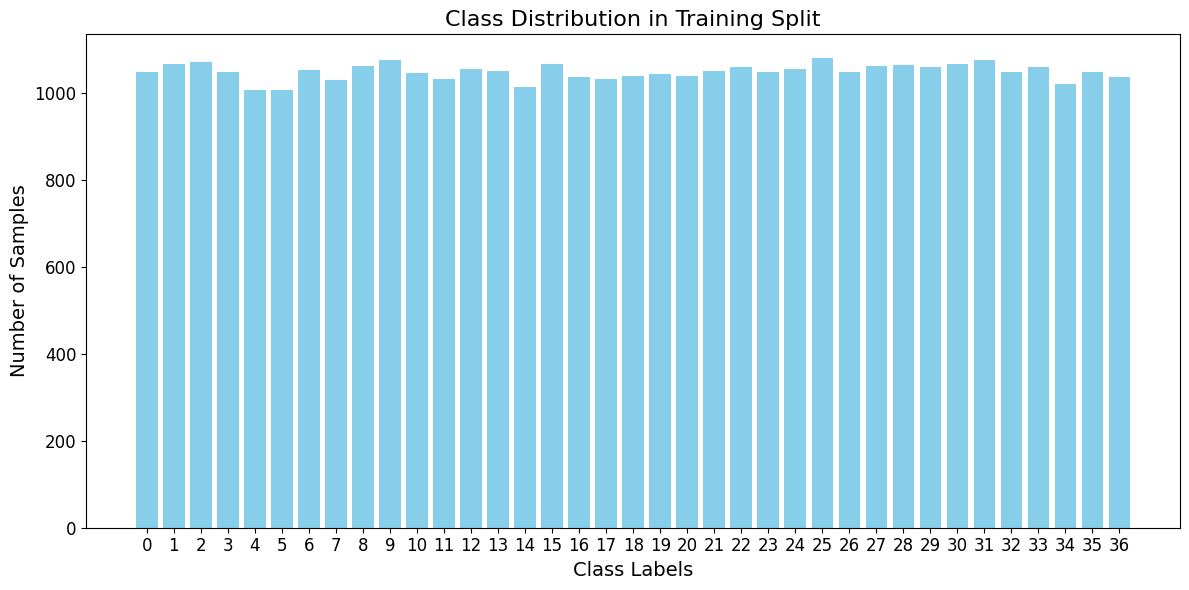

In [20]:
plot_class_distribution(train_split, "Class Distribution in Training Split")

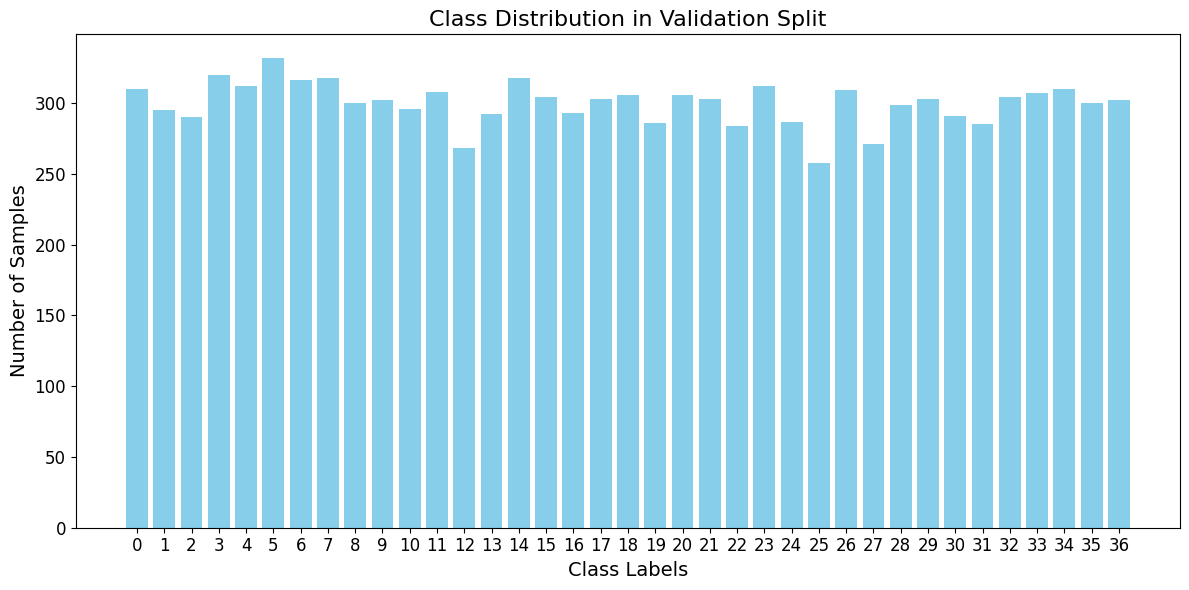

In [21]:
# Plot for validation split
plot_class_distribution(val_split, "Class Distribution in Validation Split")

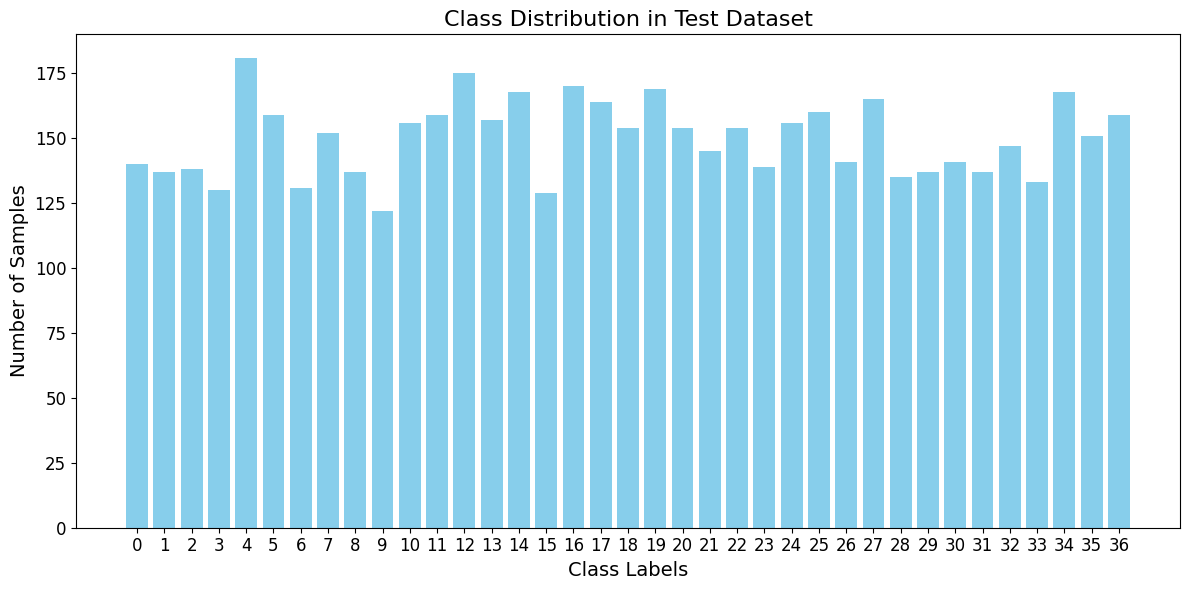

In [22]:
# Plot for test dataset
plot_class_distribution(test_split, "Class Distribution in Test Dataset")

### Model Training - Full Vit Training

#### Trainer Class

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit("vit_tiny_patch16_224", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")



Epoch 1/1


Validating: 100%|██████████| 174/174 [00:50<00:00,  3.44batch/s]

Train Loss: 0.0991, Accuracy: 0.9758
Val Loss: 0.2231, Accuracy: 0.9713
Learning rates per epoch: [0.0002]
Training completed in: 337.19 seconds


In [26]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)





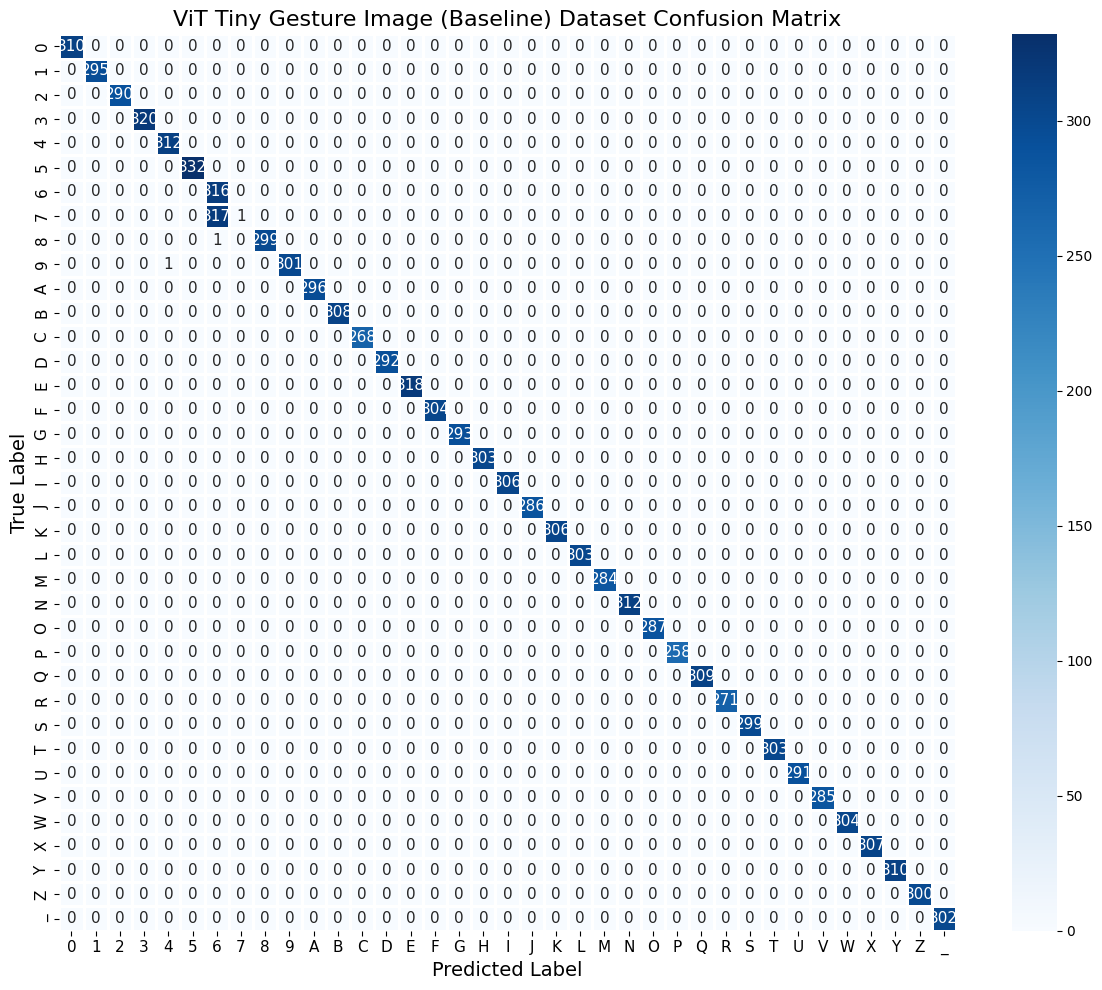

In [27]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Gesture Image (Baseline) Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


In [28]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 87/87 [00:25<00:00,  3.43batch/s]

Test Loss: 0.2150, Test Accuracy: 0.9726


In [29]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit_classification_head  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit_classification_head("vit_tiny_patch16_224", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")


Epoch 1/2


Validating: 100%|██████████| 174/174 [00:48<00:00,  3.61batch/s]


Train Loss: 0.3131, Accuracy: 0.9542
Val Loss: 0.0537, Accuracy: 0.9969
Epoch 2/2


Validating: 100%|██████████| 174/174 [00:44<00:00,  3.87batch/s]

Train Loss: 0.0314, Accuracy: 0.9988
Val Loss: 0.0209, Accuracy: 0.9990
Learning rates per epoch: [0.001, 0.001]
Training completed in: 436.03 seconds


In [30]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


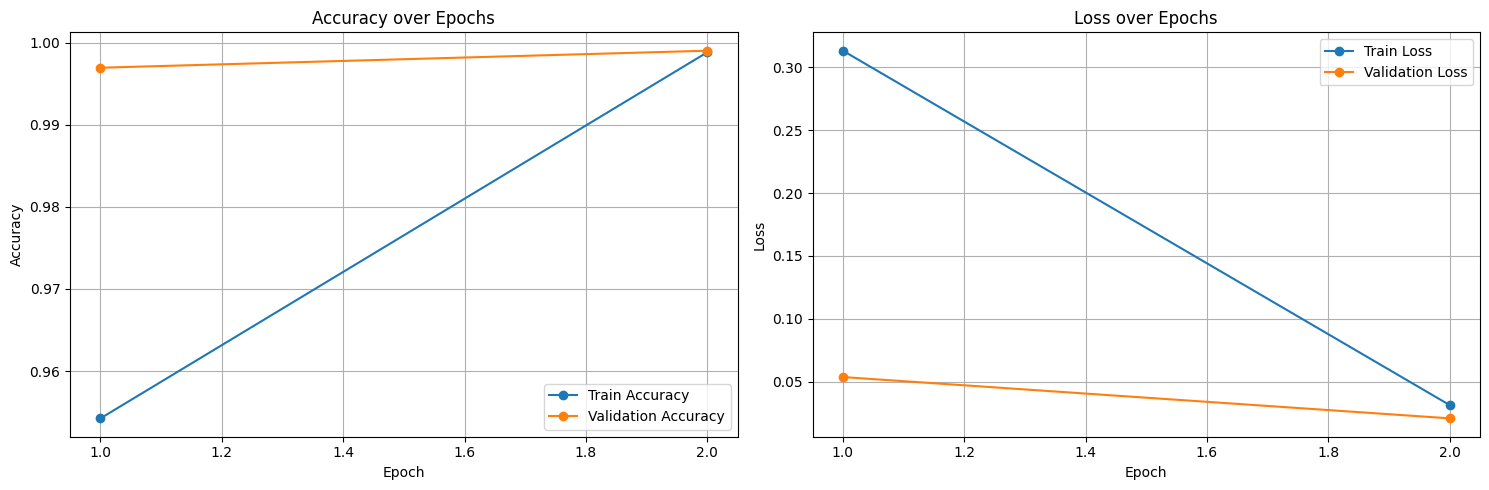

In [33]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

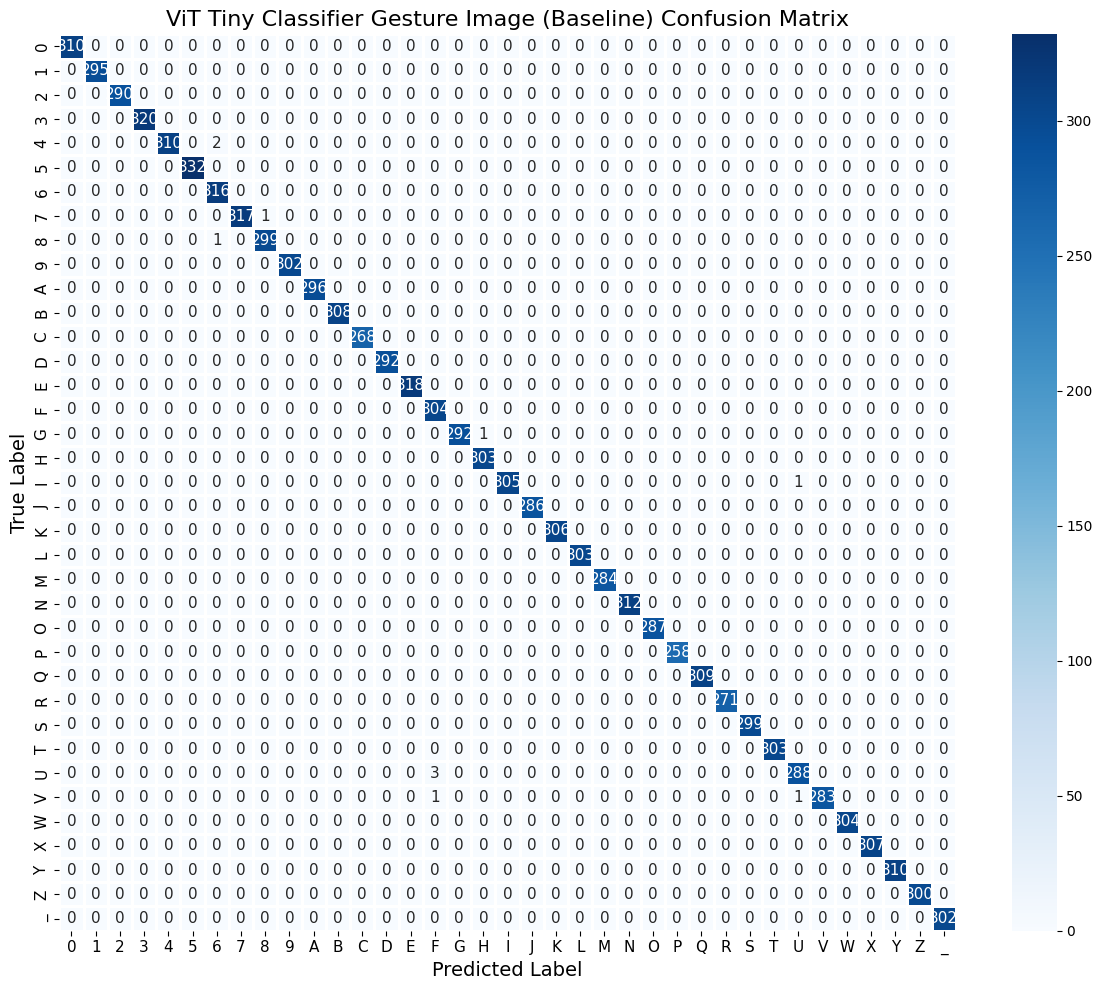

In [31]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Classifier Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [32]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 87/87 [00:19<00:00,  4.54batch/s]

Test Loss: 0.0213, Test Accuracy: 0.9989


In [46]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit_classification_head  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit_classification_head("vit_base_patch16_224", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=5e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 174/174 [47:05<00:00, 16.24s/batch]


Train Loss: 0.3593, Accuracy: 0.9581
Val Loss: 0.0618, Accuracy: 0.9976
Epoch 2/2


Validating: 100%|██████████| 174/174 [45:12<00:00, 15.59s/batch]

Train Loss: 0.0380, Accuracy: 0.9988
Val Loss: 0.0245, Accuracy: 0.9994
Learning rates per epoch: [0.0005, 0.0005]
Training completed in: 22276.78 seconds


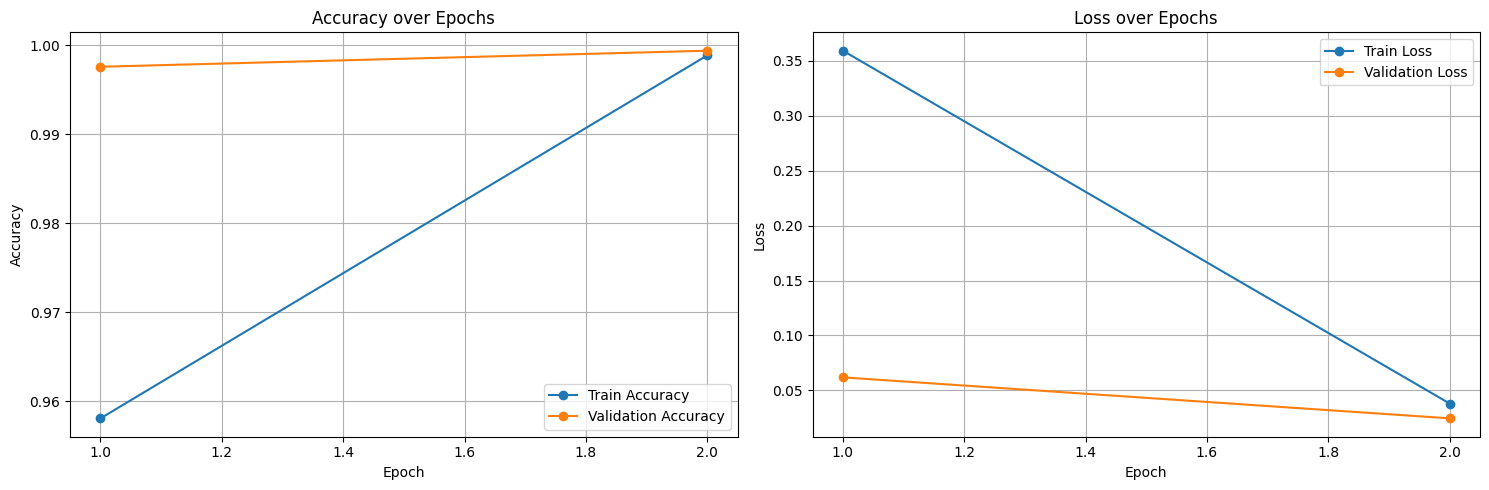

In [47]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [48]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


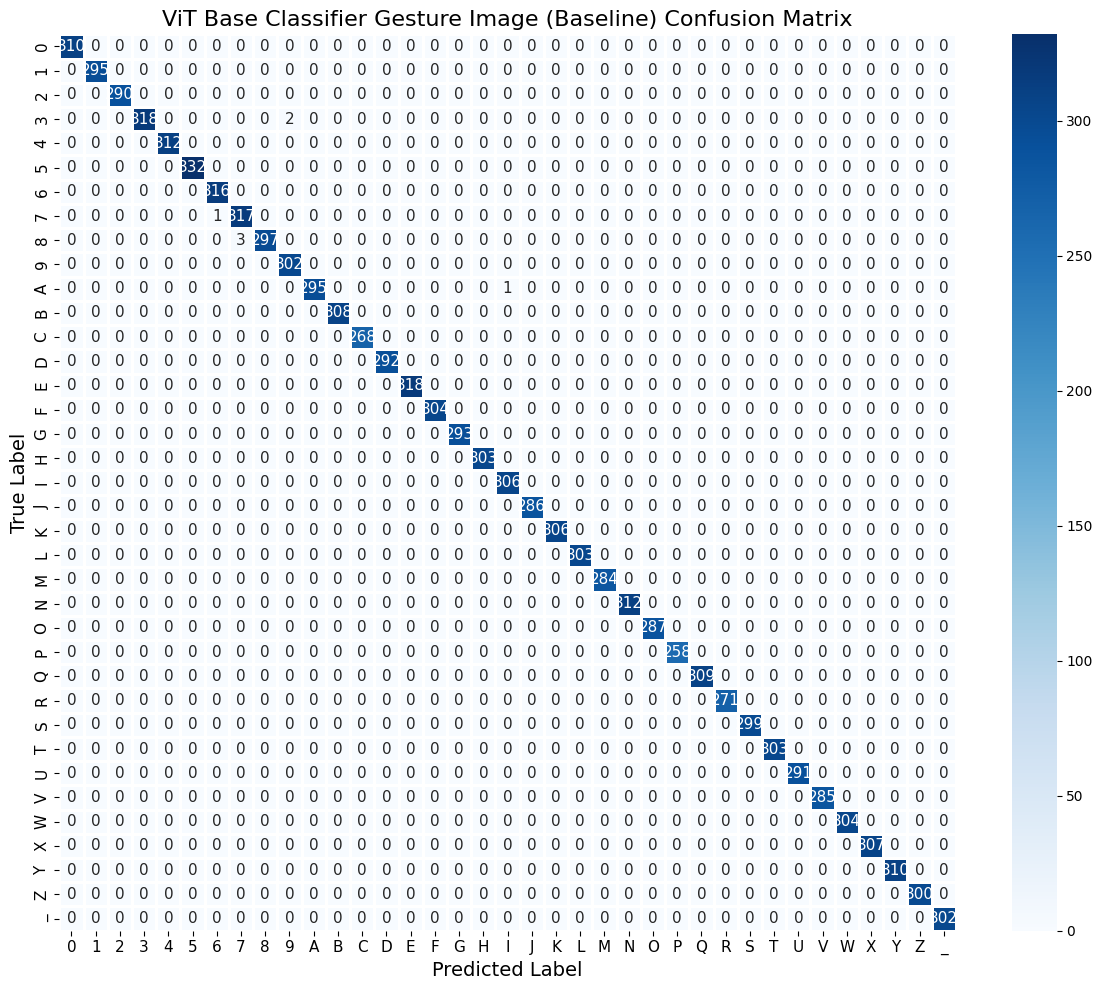

In [49]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Classifier Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [50]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 87/87 [23:21<00:00, 16.11s/batch]

Test Loss: 0.0251, Test Accuracy: 0.9995


In [6]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=37
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit("deit3_small_patch16_224.fb_in22k_ft_in1k", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/1


Validating: 100%|██████████| 174/174 [03:18<00:00,  1.14s/batch]

Train Loss: 0.0738, Accuracy: 0.9802
Val Loss: 0.0001, Accuracy: 1.0000
Learning rates per epoch: [0.0002]
Training completed in: 3139.09 seconds


In [7]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

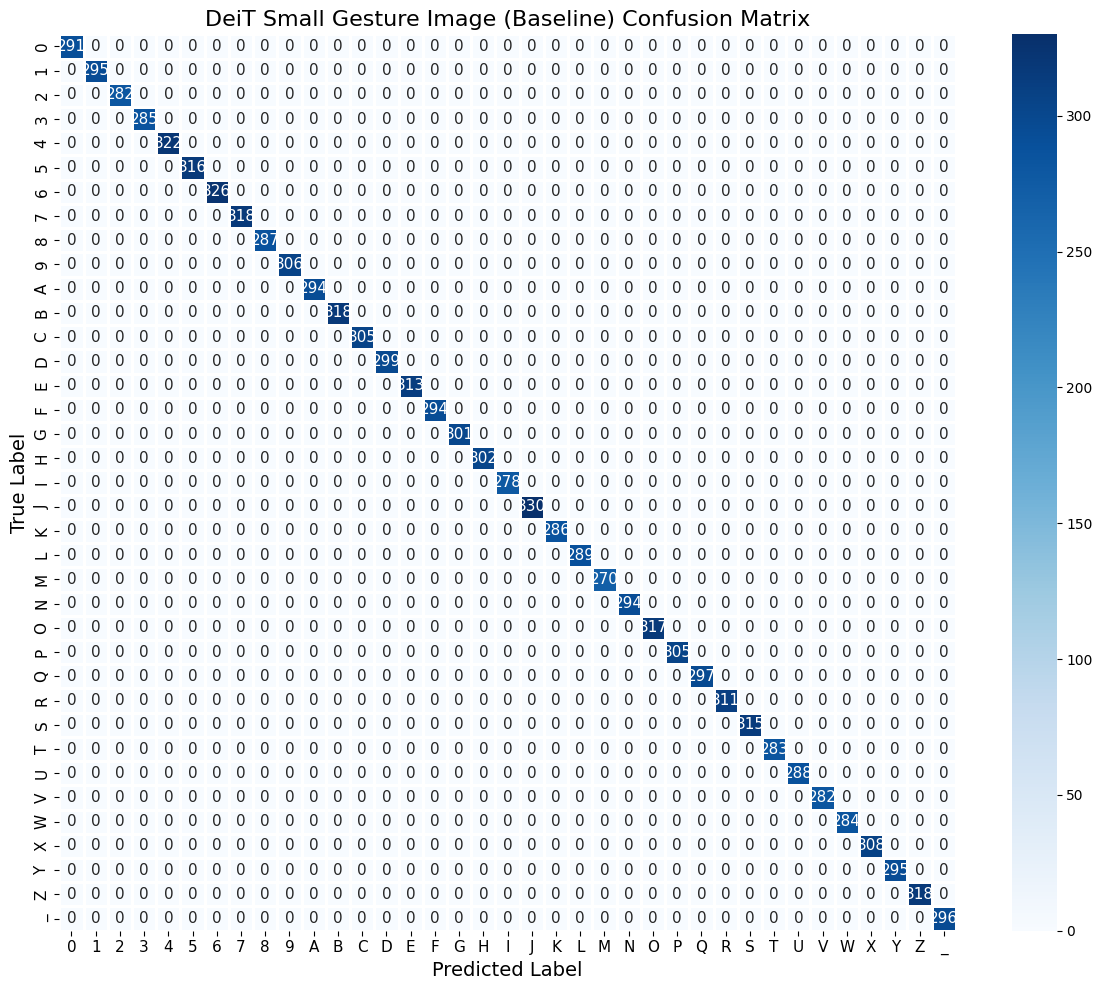

In [8]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("DeiT Small Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [9]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 87/87 [01:36<00:00,  1.11s/batch]

Test Loss: 0.0001, Test Accuracy: 1.0000


In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit("efficientvit_m5.r224_in1k", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 174/174 [00:42<00:00,  4.10batch/s]


Train Loss: 0.6518, Accuracy: 0.9494
Val Loss: 0.0346, Accuracy: 1.0000
Epoch 2/2


Validating: 100%|██████████| 174/174 [00:42<00:00,  4.12batch/s]

Train Loss: 0.0200, Accuracy: 0.9993
Val Loss: 0.0109, Accuracy: 0.9998
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 806.02 seconds


In [42]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

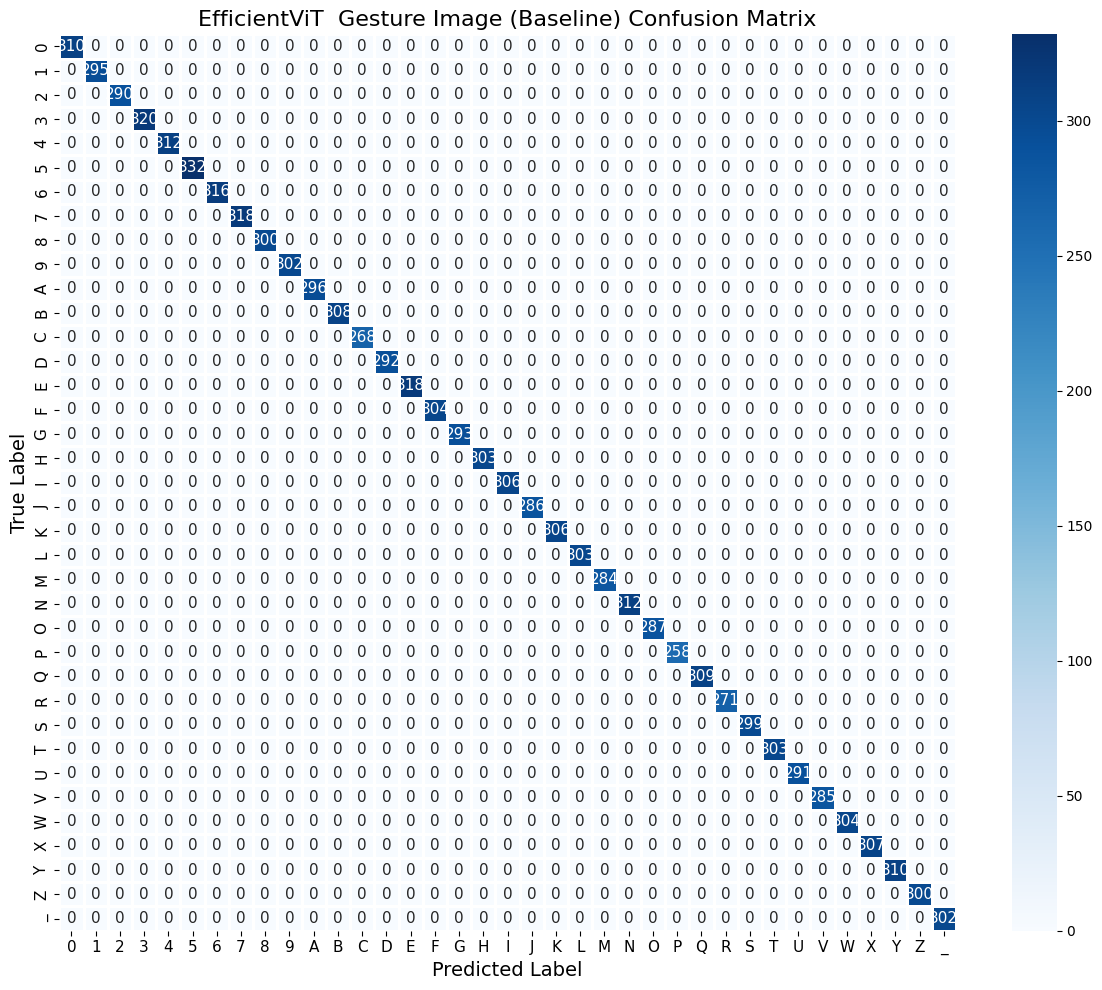

In [43]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("EfficientViT  Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

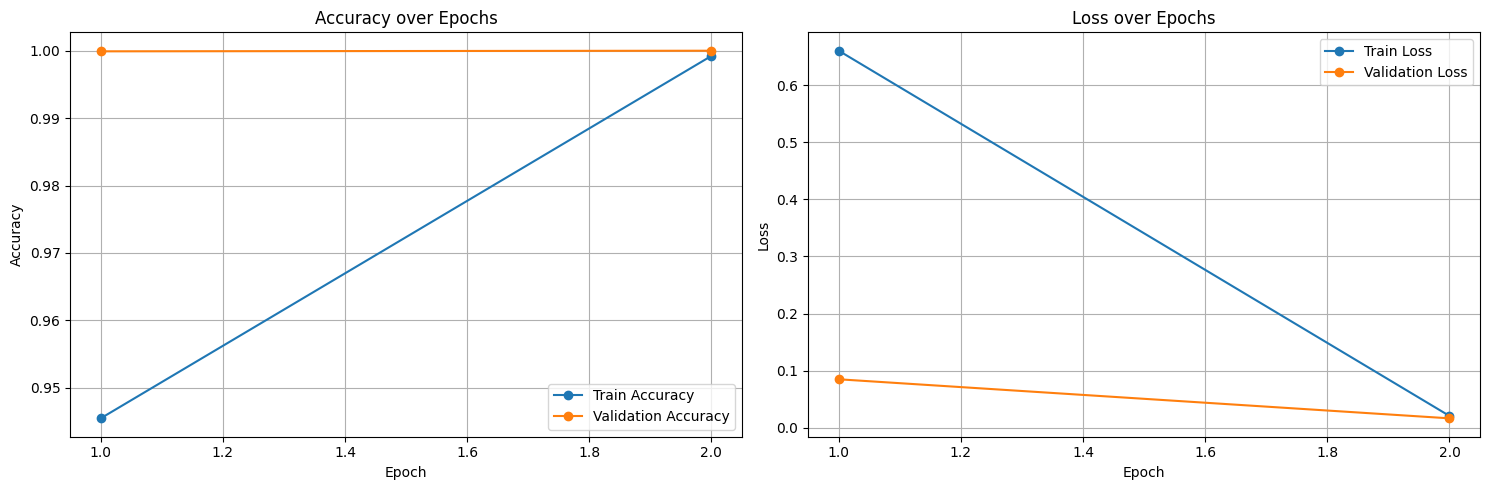

In [44]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [45]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 87/87 [01:18<00:00,  1.11batch/s]

Test Loss: 0.0165, Test Accuracy: 1.0000
